In [1]:
# Data visualization
import matplotlib.pyplot as plt

# Data manipulation
import pandas as pd
import numpy as np

import glob, re, os, sys, random
from random import shuffle
import random
from time import time

# Vector representations and embeddings
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
import gensim

# Modeling - Logistic, XGBOOST, SVM
from sklearn.model_selection import GridSearchCV, train_test_split, StratifiedShuffleSplit
from sklearn.preprocessing import LabelEncoder

from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler

from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC

from sklearn.model_selection import cross_val_predict, cross_val_score
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, precision_score, recall_score, f1_score
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_fscore_support

from sklearn.pipeline import Pipeline, FeatureUnion

from xgboost import XGBClassifier
import pickle


In [2]:
import sys
sys.path.append(f'../../../python')

from balance_split_data import create_label, balance_unique_id, \
create_balanced_excluded, create_train_test_excluded, group_by_case, create_feature_label

from grid_search import gridsearch, fit_best_model_train, evaluate, fit_best_model_test, get_feature_importance_cv

from ml_model import train_model_cross_val, train_model_test, \
get_feature_importance, get_feature_importance10

### Load data

In [3]:
df = pd.read_json(r"../../../../data/processed/pre-processed_merged_2023_04_03.json")

### Balance data and split to train and test set

In [4]:
label_name = "wc"
random_seed=42
random_state=42

In [5]:
df1 = create_label(df, label_name)
df_unique = balance_unique_id(df1)
df_balanced_unique, df_balanced, df_excluded = create_balanced_excluded(df_unique, df1, random_seed=random_seed)
df_train, df_test, df_test1 = create_train_test_excluded(df_balanced, df_balanced_unique, df_excluded, random_state=random_state)
df_train_grouped, df_test_grouped, df_test1_grouped, df_excluded_grouped = group_by_case(df_train, df_test, df_test1, df_excluded)

Total decisions: 1574
0    1313
1     261
Name: label, dtype: int64
Balancing...
Total decisions: 522
Labels distribution: 
 0    261
1    261
Name: 0, dtype: int64
Training set shape: (417,) (417,)
Test set shape: (105,) (105,)
Creating df_train 1: 209 0: 208
Creating df_test1 1: 52 0: 53
Creating df_test concatenated with df_excluded with len: 1052
Creating df_test 1: 52 0: 1105
Grouping df_train by case_num 1: 209 0: 208
Grouping df_test by case_num 1: 52 0: 1105
Grouping df_test1 by case_num 1: 52 0: 53
Grouping df_excluded by case_num with len: 1052


In [6]:
X_train, y_train, X_test, y_test, X_test1, y_test1, X_test2, y_test2 = create_feature_label(df_train_grouped, df_test_grouped, df_test1_grouped, df_excluded_grouped)

### Model training (with 10-fold CV) using best parameters from GridSearch

In [27]:
# for param_name in sorted(parameters.keys()):
#         print("\t%s: %r" % (param_name, best_parameters[param_name]))

# clf__C: 1
# tfidf__binary: True
# tfidf__max_df: 0.025
# tfidf__ngram_range: (2, 2)
# tfidf__norm: 'l1'
# tfidf__use_idf: False

	clf__C: 1
	tfidf__binary: True
	tfidf__max_df: 0.025
	tfidf__ngram_range: (2, 2)
	tfidf__norm: 'l1'
	tfidf__use_idf: False


In [7]:
vec = ('wordvec', TfidfVectorizer(analyzer = 'word', max_features=5000, stop_words='english', ngram_range = (2,2), binary = True, max_df = 0.05, norm = 'l1', use_idf = False))
c = 1
# solver = 'liblinear'
model=LinearSVC(C=c)

In [8]:
df_metrics = pd.DataFrame(columns = ['set', 'tn', 'fp', 'fn', 'tp', 'recall', 'precision', 'f_score', 'fpr', 'accuracy', 'roc_auc'])

In [9]:
# balanced train
pipeline_train, trained_model, y_predict_train = train_model_cross_val(X_train, y_train, vec=vec, model=model, cv=10)
set = "balanced train"
metrics_train=evaluate(y_train, y_predict_train)
row_train = pd.DataFrame({'set':set, 'tn':metrics_train[0], 'fp':metrics_train[1], 'fn':metrics_train[2], 'tp':metrics_train[3], \
                    'recall':metrics_train[4], 'precision':metrics_train[5], 'f_score':metrics_train[6], \
                    'fpr':metrics_train[7], 'accuracy':metrics_train[8], 'roc_auc':metrics_train[9]}, index=[0])


# balanced test
pipeline_test1, y_predict_test1 = train_model_test(X_train, y_train, X_test1, y_test1, model=model, vec=vec)
set = "balanced test"
metrics_test1=evaluate(y_test1, y_predict_test1)
row_test1 = pd.DataFrame({'set':set, 'tn':metrics_test1[0], 'fp':metrics_test1[1], 'fn':metrics_test1[2], 'tp':metrics_test1[3], \
                        'recall':metrics_test1[4], 'precision':metrics_test1[5], 'f_score':metrics_test1[6], \
                        'fpr':metrics_test1[7], 'accuracy':metrics_test1[8], 'roc_auc':metrics_test1[9]}, index=[0])


# imbalanced test
pipeline_test, y_predict_test = train_model_test(X_train, y_train, X_test, y_test, model=model, vec=vec)
set = "imbalanced test"
metrics_test=evaluate(y_test, y_predict_test)
row_test = pd.DataFrame({'set':set, 'tn':metrics_test[0], 'fp':metrics_test[1], 'fn':metrics_test[2], 'tp':metrics_test[3], \
                    'recall':metrics_test[4], 'precision':metrics_test[5], 'f_score':metrics_test[6], \
                    'fpr':metrics_test[7], 'accuracy':metrics_test[8], 'roc_auc':metrics_test[9]}, index=[0])

df_metrics = pd.concat([df_metrics.loc[:], row_train, row_test1, row_test]).reset_index(drop=True)
df_metrics['n'] = df_metrics['tn'] + df_metrics['fp'] + df_metrics['fn'] + df_metrics['tp']

***10-fold cross-validation***
Accuracy: 0.6363636363636364

Classification report:
               precision    recall  f1-score   support

           0       0.79      0.37      0.50       208
           1       0.59      0.90      0.71       210

    accuracy                           0.64       418
   macro avg       0.69      0.64      0.61       418
weighted avg       0.69      0.64      0.61       418


CR: (0.6881696428571429, 0.6350961538461539, 0.6082377605130102, None)

Confusion matrix:
 [[ 77 131]
 [ 21 189]] 

_______________________


 Accuracy: 63.636 
 Precision: 0.591 
 Recall: 0.900 
 F1: 0.713 
 FPR: 0.630 
 ROC_AUC: 0.635
Accuracy: 0.6363636363636364

Classification report:
               precision    recall  f1-score   support

           0       0.79      0.37      0.50       208
           1       0.59      0.90      0.71       210

    accuracy                           0.64       418
   macro avg       0.69      0.64      0.61       418
weighted avg       0.69 

In [12]:
df_metrics

,set,tn,fp,fn,tp,recall,precision,f_score,fpr,accuracy,roc_auc,n
0,balanced train,77,131,21,189,0.900000,0.590625,0.713208,0.629808,63.636364,0.635096,418
1,balanced test,26,27,3,50,0.943396,0.649351,0.769231,0.509434,71.698113,0.716981,106
2,imbalanced test,628,477,3,50,0.943396,0.094877,0.172414,0.431674,58.549223,0.755861,1158


In [13]:
df_metrics.to_excel('../../../../output/tables/svm_metrics_wc.xlsx', index=True)

### Confusion matrix and model performance

In [14]:
merger_info = pd.read_json(r"../../../../data/processed/merger_info_2023_03_25.json")

In [21]:
def eval_matrix(df, X, y_true, y_pred):
    results = pd.DataFrame(np.column_stack((X, y_true, y_pred)), columns=['text', 'target', 'y_predict'])
    results = pd.concat([df, results], axis=1)
    results = pd.merge(results, merger_info, how='left', left_on=['case_num', 'article'], right_on=['case_code', 'article'])

    tn=results[(results.target == 0) & (results.y_predict == 0)]
    fp=results[(results.target == 0) & (results.y_predict == 1)]
    fn=results[(results.target == 1) & (results.y_predict == 0)]
    tp=results[(results.target == 1) & (results.y_predict == 1)]

    return (results, tn, fp, fn, tp)


In [22]:
results_train, tn, fp, fn, tp = eval_matrix(df_train_grouped, X_train, y_train, y_predict_train)

In [23]:
results1, tn, fp, fn, tp = eval_matrix(df_test1_grouped, X_test1, y_test1, y_predict_test1)

In [24]:
results2, tn, fp, fn, tp = eval_matrix(df_test_grouped, X_test, y_test, y_predict_test)

In [27]:
print("TN:", len(tn))
print("FP:", len(fp))

print("FN:", len(fn))
print("TP:", len(tp))

TN: 628
FP: 477
FN: 3
TP: 50


In [29]:
tn['nace_code'].value_counts().head(6)

Manufacture of chemicals and chemical products                                   15
Manufacture of other parts and accessories for motor vehicles                    12
Financial service activities, except insurance and pension funding                9
Wholesale of computers, computer peripheral equipment and software                9
Insurance, reinsurance and pension funding, except compulsory social security     9
Electric power generation, transmission and distribution                          8
Name: nace_code, dtype: int64

In [30]:
fp['nace_code'].value_counts().head(6)

Telecommunications                                                                                                    32
Manufacture of basic pharmaceutical products and pharmaceutical preparations                                          14
Manufacture of chemicals and chemical products                                                                        11
Manufacture of basic chemicals, fertilisers and nitrogen compounds, plastics and synthetic rubber in primary forms     9
Manufacture of other parts and accessories for motor vehicles                                                          8
Computer programming, consultancy and related activities                                                               7
Name: nace_code, dtype: int64

In [31]:
fp['nace_code'].str.contains("pharma").sum()

30

In [32]:
fn['nace_code'].value_counts().head(6)

Manufacture of chemicals and chemical products                                                                                                                                                       1
Electric power generation, transmission and distribution                                                                                                                                             1
Cargo handling; Land transport and transport via pipelines; Sea and coastal freight water transport; Service activities incidental to water transportation; Support activities for transportation    1
Name: nace_code, dtype: int64

In [33]:
tp['nace_code'].value_counts().head(6)

Manufacture of basic pharmaceutical products and pharmaceutical preparations                   8
Manufacture of chemicals and chemical products                                                 3
Information service activities; Programming and broadcasting activities; Telecommunications    2
Wireless telecommunications activities                                                         2
Aquaculture                                                                                    2
Processing and preserving of fruit and vegetables; Wholesale of fruit and vegetables           1
Name: nace_code, dtype: int64

### Feature importance

In [34]:
df_features_train, feature_importance, feature_names = get_feature_importance(trained_model, pipeline_train)
df_features_train.head(10)

,feature,importance,abs_importance
3321,personal care,0.550350,0.550350
82,acquire joint,-0.539889,0.539889
734,company headquartered,0.523181,0.523181
726,company controlled,-0.505672,0.505672
2078,hold minority,0.491876,0.491876
4242,share asset,0.482619,0.482619
3114,otc pharmaceutical,0.480743,0.480743
2325,investment banking,-0.418974,0.418974
2330,investment management,-0.404025,0.404025
2365,jv comp,-0.397829,0.397829


Get features for label = 1 and label = 0

In [35]:
df_features_train1, df_features_train0 = get_feature_importance10(df_features_train)

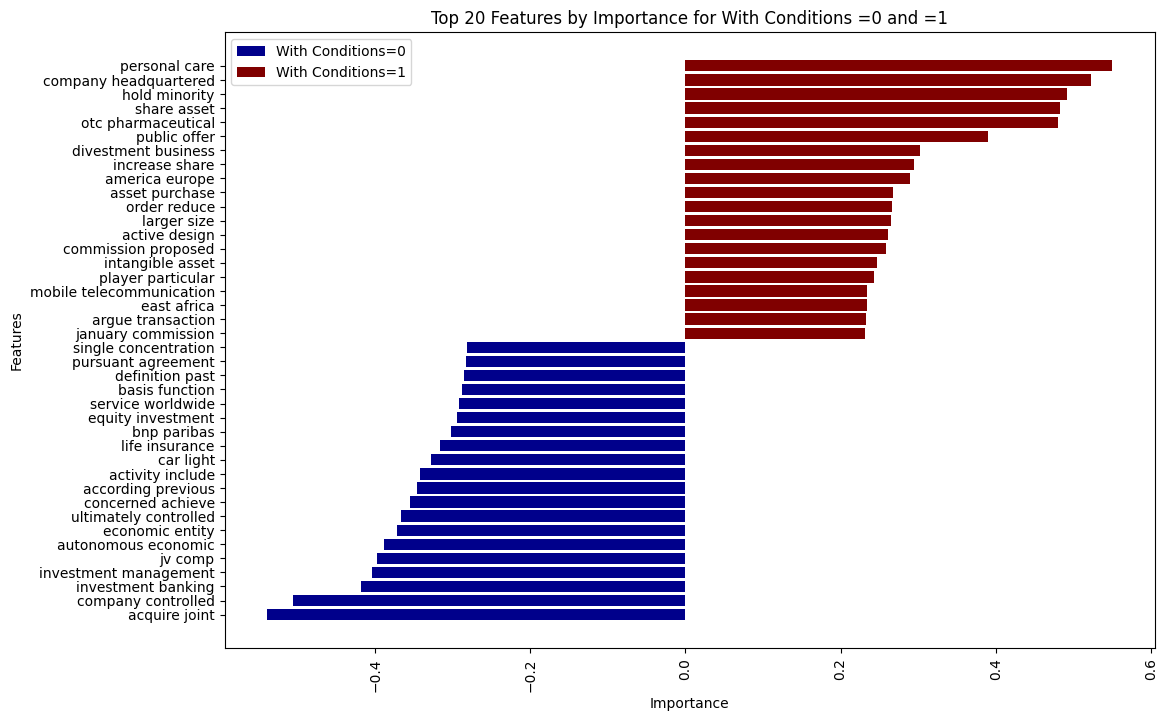

<Figure size 640x480 with 0 Axes>

In [37]:
# Sort the features by absolute importance for label=1
df_features_train1 = df_features_train1.sort_values(by='abs_importance', ascending=False)
df_features_train1_top10 = df_features_train1.nlargest(20, 'abs_importance')
df_features_train1_top10 = df_features_train1_top10.sort_values('importance', ascending=True)

# Sort the features by absolute importance for label=0
df_features_train0 = df_features_train0.sort_values(by='abs_importance', ascending=False)
df_features_train0_top10 = df_features_train0.nlargest(20, 'abs_importance')

# Create a combined bar chart
fig, ax = plt.subplots(figsize=(12, 8))
ax.barh(df_features_train0_top10['feature'], df_features_train0_top10['importance'], color='darkblue', label='With Conditions=0')
ax.barh(df_features_train1_top10['feature'], df_features_train1_top10['importance'], color='maroon', label='With Conditions=1')
ax.set_xlabel('Importance')
ax.set_ylabel('Features')
ax.set_title('Top 20 Features by Importance for With Conditions =0 and =1')
ax.legend()
plt.xticks(rotation=90)
plt.show()

plt.savefig('../../../../output/figures/svm_full_wc.png', bbox_inches='tight')

In [38]:
df_features_train.to_excel('../../../../output/tables/features_svm_train_full_wc.xlsx', index=True)